# Interacting with NeuroMechFly

**Summary:** In this tutorial, we will introduce the basic concepts of interacting with the simulated fly in a Markov Decision Process using the Gym interface. As a demonstration, we will replay experimentally recorded leg kinematics during walking in the simulator.

Markov Decision Process (MDP) and the Gym API
---------------------------------------------

We formulated the control of NeuroMechFly as a partially observable Markov Decision Process (MDP). At each time step, the simulation provides the controller with an observation and, optionally, a user-defined reward. Then, the simulation receives an action from the controller and steps the physics forward accordingly. The observation space is a user-configurable subset of the state space including visual inputs, olfactory inputs, ground contacts, joint states (angles, angular velocities, and torques), and the position and velocity of the fly model within the arena. The action space includes the control signal (e.g. angles for position control) for every actuated joint (e.g. 7 degrees-of-freedom (DoFs) per leg * 6 legs) and the on/off signal for leg adhesion. This framework is easily extendable: the user can incorporate additional layers of sensory preprocessing or premotor computation into the MDP.

| ![](https://github.com/NeLy-EPFL/_media/blob/main/flygym/mdp.png?raw=true) | 
|:--:| 
| *The biomechanical model and its interaction with the environment are encapsulated as a MDP task. A user-defined controller interfaces with the task through actions (red) and observations (blue). The user can extend the MDP task by adding preprogrammed processing routines for motor outputs (purple) and sensory inputs (light blue), to modify the action and observation spaces handled by the controller.* |


Our implementation of the partially observable MDP complies with the [Gymnasium API](https://gymnasium.farama.org/). Gymnasium (a continuation of the now deprecated OpenAI Gym) is a package and standardized interface for developing and comparing control algorithms and benchmarking tasks. It provides a diverse collection of environments, ranging from classic control problems, Atari games, board games, and robotics simulations. Gym environments are designed to offer a common interface for controllers, in particular reinforcement learning agents, to interact with. This standardization makes it easier to develop and compare algorithms.

The overall steps for interacting with a Gym environment are:

1. Defining an environment
2. Reset the environment and get the initial observation
3. Interact with the environment with a loop:
   - Based on the last observation, the controller decides which actions to take
   - Step the simulation, applying the selected actions. The simulation will return you the new observation (and optionally some additional information)
   - Optional: render the simulation graphically
   - Break if certain conditions are met (e.g. task is accomplished or failed), otherwise continue

4. Close the environment and analyze the results

This process is illustrated in the following code snippet:

```Python
env = MyEnvironment(...)
obs, info = env.reset()

for step in range(1000):    # let's simulate 1000 steps max
    action = ...    # your controller decides what to do based on obs
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break

env.close()
```

Note that the action can be selected by any means defined by the user (e.g. preprogrammed rules, algorithmic models, artificial neural networks).

### The action and observation spaces
The **action** is a dictionary with the following keys and values:

- **"joints"**: The control signal for the actuated DoFs (e.g. if ``NeuroMechFly.control == "position"``, then this is the target joint angle). This is a NumPy array of shape (|actuated_joints|,). The order of the DoFs is the same as ``NeuroMechFly.actuated_joints``.
- **"adhesion"** (if ``sim_params.enable_adhesion`` is True): The on/off signal of leg adhesion as a NumPy array of shape (6,), one for each leg. The order of the legs is: LF, LM, LH, RF, RM, RH (L/R = left/right, F/M/H = front/middle/hind).

The **observation** is a dictionary with the following keys and values:

- **"joints"**: The joint states as a NumPy array of shape (3, |actuated_joints|). The three rows are the angle, angular velocity, and force at each DoF. The order of the DoFs is the same as ``NeuroMechFly.actuated_joints``
- **"fly"**: The fly state as a NumPy array of shape (4, 3). 0th row: x, y, z position of the fly in arena. 1st row: x, y, z velocity of the fly in arena. 2nd row: orientation of fly around x, y, z axes. 3rd row: rate of change of fly orientation.
- **"contact_forces"**: Readings of the touch contact sensors, one placed for each of the body segments specified in ``NeuroMechFly.contact_sensor_placements``. This is a NumPy array of shape (|contact_sensor_placements|, 3)
- **"end_effectors"**: The positions of the end effectors (most distal tarsus link) of the legs as a NumPy array of shape (6, 3). The order of the legs is: LF, LM, LH, RF, RM, RH (L/R = left/right, F/M/H = front/middle/hind). 
- **"fly_orientation"**: NumPy array of shape (3,). This is the vector (x, y, z) pointing toward the direction that the fly is facing.
- **"vision"** (if ``sim_params.enable_vision`` is True): The light intensities sensed by the ommatidia on the compound eyes. This is a NumPy array of shape (2, num_ommatidia_per_eye, 2), where the zeroth dimension is the side (left, right in that order); the second dimension specifies the ommatidium, and the last column is for the spectral channel (yellow-type, pale-type in that order). Each ommatidium only has one channel with nonzero reading. The intensities are given on a [0, 1] scale.
- **"odor_intensity"** (if ``sim_params.enable_olfaction`` is True): The odor intensities sensed by the odor sensors (by default 2 antennae and 2 maxillary palps). This is a NumPy array of shape (odor_space_dimension, num_sensors).

### `terminated`, `truncated`, and the `info` dictionary
In the Gym API, the `step()` method returns a `terminated` flag indicating whether the simulation has ended due to a condition under the MDP formulation (e.g. task success/failure). The `step()` method also returns a `truncated` flag indicating whether the simulation has ended due to a condition outside the MDP formulation (e.g. timeout). The provided `NeuroMechFly` environment always returns False for both `terminated` and `truncated`. The user can modify this behavior by extending the `NeuroMechFly` class.

Additionally, the `step()` method returns an `info` dictionary that contains arbitrary auxiliary information. The user can add any information to this dictionary by extending the `NeuroMechFly` class. The provided `NeuroMechFly` contains the following keys and values in the **`info` dictionary**:

- **"raw_vision"** (if ``sim_params.enable_vision`` and ``sim_params.render_raw_vision`` are both True): The eye camera rendering before it is transformed into ommatidia readings. This is a NumPy array of shape (2, nrows, ncols, 3) where the zeroth dimension is for the side (left, right in that order). The rest are the RGB image.

## Example: Kinematic replay of experimentally recorded behavior

We now move on to an example where we kinematically replay some experimentally recorded walking behaviors. Specifically, we recorded a tethered fly walking on an air-suspended spherical treadmill using seven zoomed-in cameras from different angles. We then estimated the 3D positions of keypoints on the joints using DeepFly3D (Günel et al., *Elife* 2019) and used inverse kinematics to calculate the angle at each DoF. With these we will use a PD controller to actuate the DoFs of the simulated fly at using these exact angles to see if the fly can walk untethered on flat terrain, as shown in the original NeuroMechFly paper (Lobato-Rios et al., *Nature Methods* 2022).

We start with the necessary imports:

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from flygym import Fly, Camera, SingleFlySimulation, get_data_path
from flygym.preprogrammed import all_leg_dofs

Let's define some simulation parameters:

In [2]:
run_time = 0.5
timestep = 1e-4
actuated_joints = all_leg_dofs

We can now load recorded kinematics that are included with the FlyGym package:

In [3]:
data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "single_steps_untethered.pkl", "rb") as f:
    data = pickle.load(f)

The dataset is provided at 2000 Hz. We will try to run the simulation at $\Delta t=0.0001s$ (10000 Hz), so let's interpolate it 5x:

In [4]:
target_num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

We can visualize the time series of DoF angles:

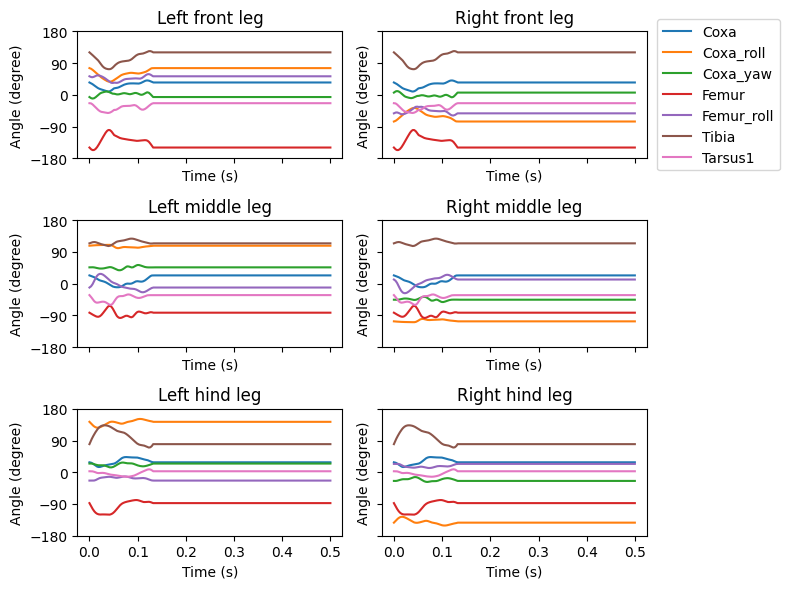

In [5]:
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.ravel()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

Path("outputs/").mkdir(exist_ok=True)
fig.savefig("outputs/kin_replay_joint_dof_time_series.png")

Now we can create a NeuroMechFly simulation instance and play out the recorded kinematics in the MDP loop:

In [6]:
import cv2
import numpy as np
from tqdm import trange
from flygym import Fly, Simulation, Camera
from flygym.arena import FlatTerrain
from flygym.preprogrammed import all_leg_dofs

In [7]:
import sys
sys.path.append('C:/Users/laeti/Documents/laetitia/EPFL/Master/CoursMA2/Control_Behaviour/projet')

In [8]:
#from hybrid_turning_fly import HybridTurningFly
#from simulation_CPG import Simulation_CPG
from flygym.examples.cpg_controller import CPGNetwork

In [9]:
joint_pos = data_block[:, 0]

joint_copy = joint_pos.copy()

for index, joint_name in enumerate(all_leg_dofs):
    print(f"The index of {joint_name} is: {index} and its value is: {joint_pos[index]}")

The index of joint_LFCoxa is: 0 and its value is: 0.6101972030438495
The index of joint_LFCoxa_roll is: 1 and its value is: 1.3210939440118634
The index of joint_LFCoxa_yaw is: 2 and its value is: -0.11010560617625621
The index of joint_LFFemur is: 3 and its value is: -2.6088083527331203
The index of joint_LFFemur_roll is: 4 and its value is: 0.9167297616699835
The index of joint_LFTibia is: 5 and its value is: 2.1007223011827314
The index of joint_LFTarsus1 is: 6 and its value is: -0.4147644798944433
The index of joint_LMCoxa is: 7 and its value is: 0.4021857392798495
The index of joint_LMCoxa_roll is: 8 and its value is: 1.8716872992434352
The index of joint_LMCoxa_yaw is: 9 and its value is: 0.800527456068429
The index of joint_LMFemur is: 10 and its value is: -1.443255104212899
The index of joint_LMFemur_roll is: 11 and its value is: -0.19805688843256214
The index of joint_LMTibia is: 12 and its value is: 1.9888996570222486
The index of joint_LMTarsus1 is: 13 and its value is: -0.5

In [10]:
import time

class MovingFly(Fly):
    def __init__(self, init_pose="stretch", actuated_joints=None, control="position",
                 initial_position=None, initial_orientation=None):
        super().__init__(init_pose=init_pose, actuated_joints=actuated_joints, control=control,
                         spawn_pos=initial_position, spawn_orientation=initial_orientation)


    #def simulate_step(self, sim: Simulation):
        # Simulate one step with updated joint angles
        #obs, info = sim.reset()

        #for i in trange(target_num_steps):
            #obs, reward, terminated, truncated, info = self.simulate_movement(sim, target_num_steps, yaw_angle, increment, delay)
            #action = {"joints": joint_pos}
            #obs, reward, terminated, truncated, info = sim.step(action)
            #sim.render()


    def simulate_step(self, sim: Simulation, target_num_steps: int, yaw_angle: float, increment: float = 0.00015, delay: float = 0.05, perform_movement: bool = False):
    # Simulate one step with updated joint angles
        obs, info = sim.reset()
        
        if not perform_movement:
            if "joints" not in obs:
                print("Warning: 'joints' not found in observation.")
                return

            joint_pos = obs["joints"]  # Define joint_pos if not performing movement

        for i in trange(target_num_steps):
            if perform_movement:
                # Update joint positions using simulate_movement method
                # Side helps to compute from which side the fly arrives
                side: str='L'
                obs, reward, terminated, truncated, info = self.simulate_movement(sim, target_num_steps, yaw_angle, increment, delay, side)
                if "joints" not in obs:
                    print("Warning: 'joints' not found in observation.")
                    return
                joint_pos = obs["joints"]  # Update joint_pos after movement
            else:
                # Continue with regular step
                if "joints" not in obs:
                    print("Warning: 'joints' not found in observation.")
                    return
                action = {"joints": joint_pos}
                obs, reward, terminated, truncated, info = sim.step(action)
                joint_pos = obs["joints"]

            sim.render()
        
        sim.render()




    def simulate_movement(self, sim: Simulation, target_num_steps: int, yaw_angle :float, increment: float, delay: float, side: str):
        obs, info = sim.reset()
        joint_pos = obs["joints"]

        for i in trange(target_num_steps):
            # update the Femur, Tibia and Tarsus joints to 0
            if (side == "L"):
                joint_pos[8] = 0
                joint_pos[10] = 0
                joint_pos[11] = 0
                joint_pos[12] = 0
                joint_pos[13] = 0
            else:
                joint_pos[29] = 0
                joint_pos[31] = 0
                joint_pos[32] = 0
                joint_pos[33] = 0
                joint_pos[34] = 0

            # update LMCoxa_yaw to the desired angle
            if (side == "L"):
                while joint_pos[9] < yaw_angle:
                    joint_pos[9] += increment
            else:
                while joint_pos[30] < yaw_angle:
                    joint_pos[30] += increment

            # update LMCoxa_pitch to the horizontal
            if (side == "L"):
                while joint_pos[7] < 1.5:
                    joint_pos[7] += increment
            else:
                while joint_pos[28] < 1.5:
                    joint_pos[28] += increment

            action = {"joints": joint_pos}
            obs, reward, terminated, truncated, info = sim.step(action)
            sim.render()
            time.sleep(delay)

        return obs, reward, terminated, truncated, info



In [11]:
arena = FlatTerrain()

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

fly = MovingFly(init_pose="stretch",
                        actuated_joints=actuated_joints,
                        control="position",
                        initial_position=[0, 0, 0],
                        initial_orientation=[0, 0, 0])

cam1 = Camera(fly=fly, play_speed=0.2, draw_contacts=True)

cam2 = Camera(
    fly=fly,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

sim = Simulation(
    flies=[fly],
    cameras=[cam1, cam2],
    arena=arena,
)

In [12]:
# Simulate the behaving fly 
# if perform_movement = False, the fly will not be moving its middle leg
# if perform_movement = True, the fly will be moving its middle leg to reach the other fly
fly.simulate_step(sim, target_num_steps, yaw_angle=2)

# Save videos and display
cam1.save_video("./outputs/kinematic_B_replay1.mp4")
cam2.save_video("./outputs/kinematic_B_replay2.mp4")

#from IPython import display
#display.Video("./outputs/kinematic_B_replay1.mp4")